# see Danieles Mail from 28.01.25

In [1]:
from utils.binaries import *
from utils.plotting import *
from utils.Auger.SD import UubRandoms

17:46:44 (   +8.1s) [INFO   ] -- import logging
17:46:44 (  +215ms) [INFO   ] -- import numpy as np
17:46:44 (   +12ms) [INFO   ] -- import uncertainties
17:46:45 (  +657ms) [INFO   ] -- import pandas as pd
17:46:45 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
17:46:45 (    +1ms) [INFO   ] -- import binaries.tools as tools
17:46:46 (  +528ms) [INFO   ] -- import matplotlib.pyplot as plt
17:46:46 (  +819ms) [INFO   ] -- import seaborn as so
17:46:46 (    +2ms) [INFO   ] -- import plotting.tools as plot
17:46:46 (   +22ms) [DEBUG  ] -- font size set to 9.5
17:46:46 (    +0ms) [DEBUG  ] -- label size set to 13.0
17:46:46 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
17:46:46 (    +1ms) [DEBUG  ] -- markersize set to 2.0
17:46:46 (    +0ms) [DEBUG  ] -- usetex set to False


In [2]:
RandomFiles = UubRandoms.UubRandom(station = "Svenja", detectors = "ssd")

px = np.zeros(10000)
pulse_heights = []

for File in tools.ProgressBar(RandomFiles):
    for trace in File:

        _max = np.max(trace['trace'])
        px[_max] += 1

        if _max >= 70:
            pulse_heights.append(_max)

tools.pickle_save('pulse_height_distribution.pkl', px)
print(f"{np.mean(pulse_heights) = :.4f}")
print(f"{np.std(pulse_heights) = :.4f}")

KeyboardInterrupt: 

In [3]:
px = tools.pickle_load('pulse_height_distribution.pkl')

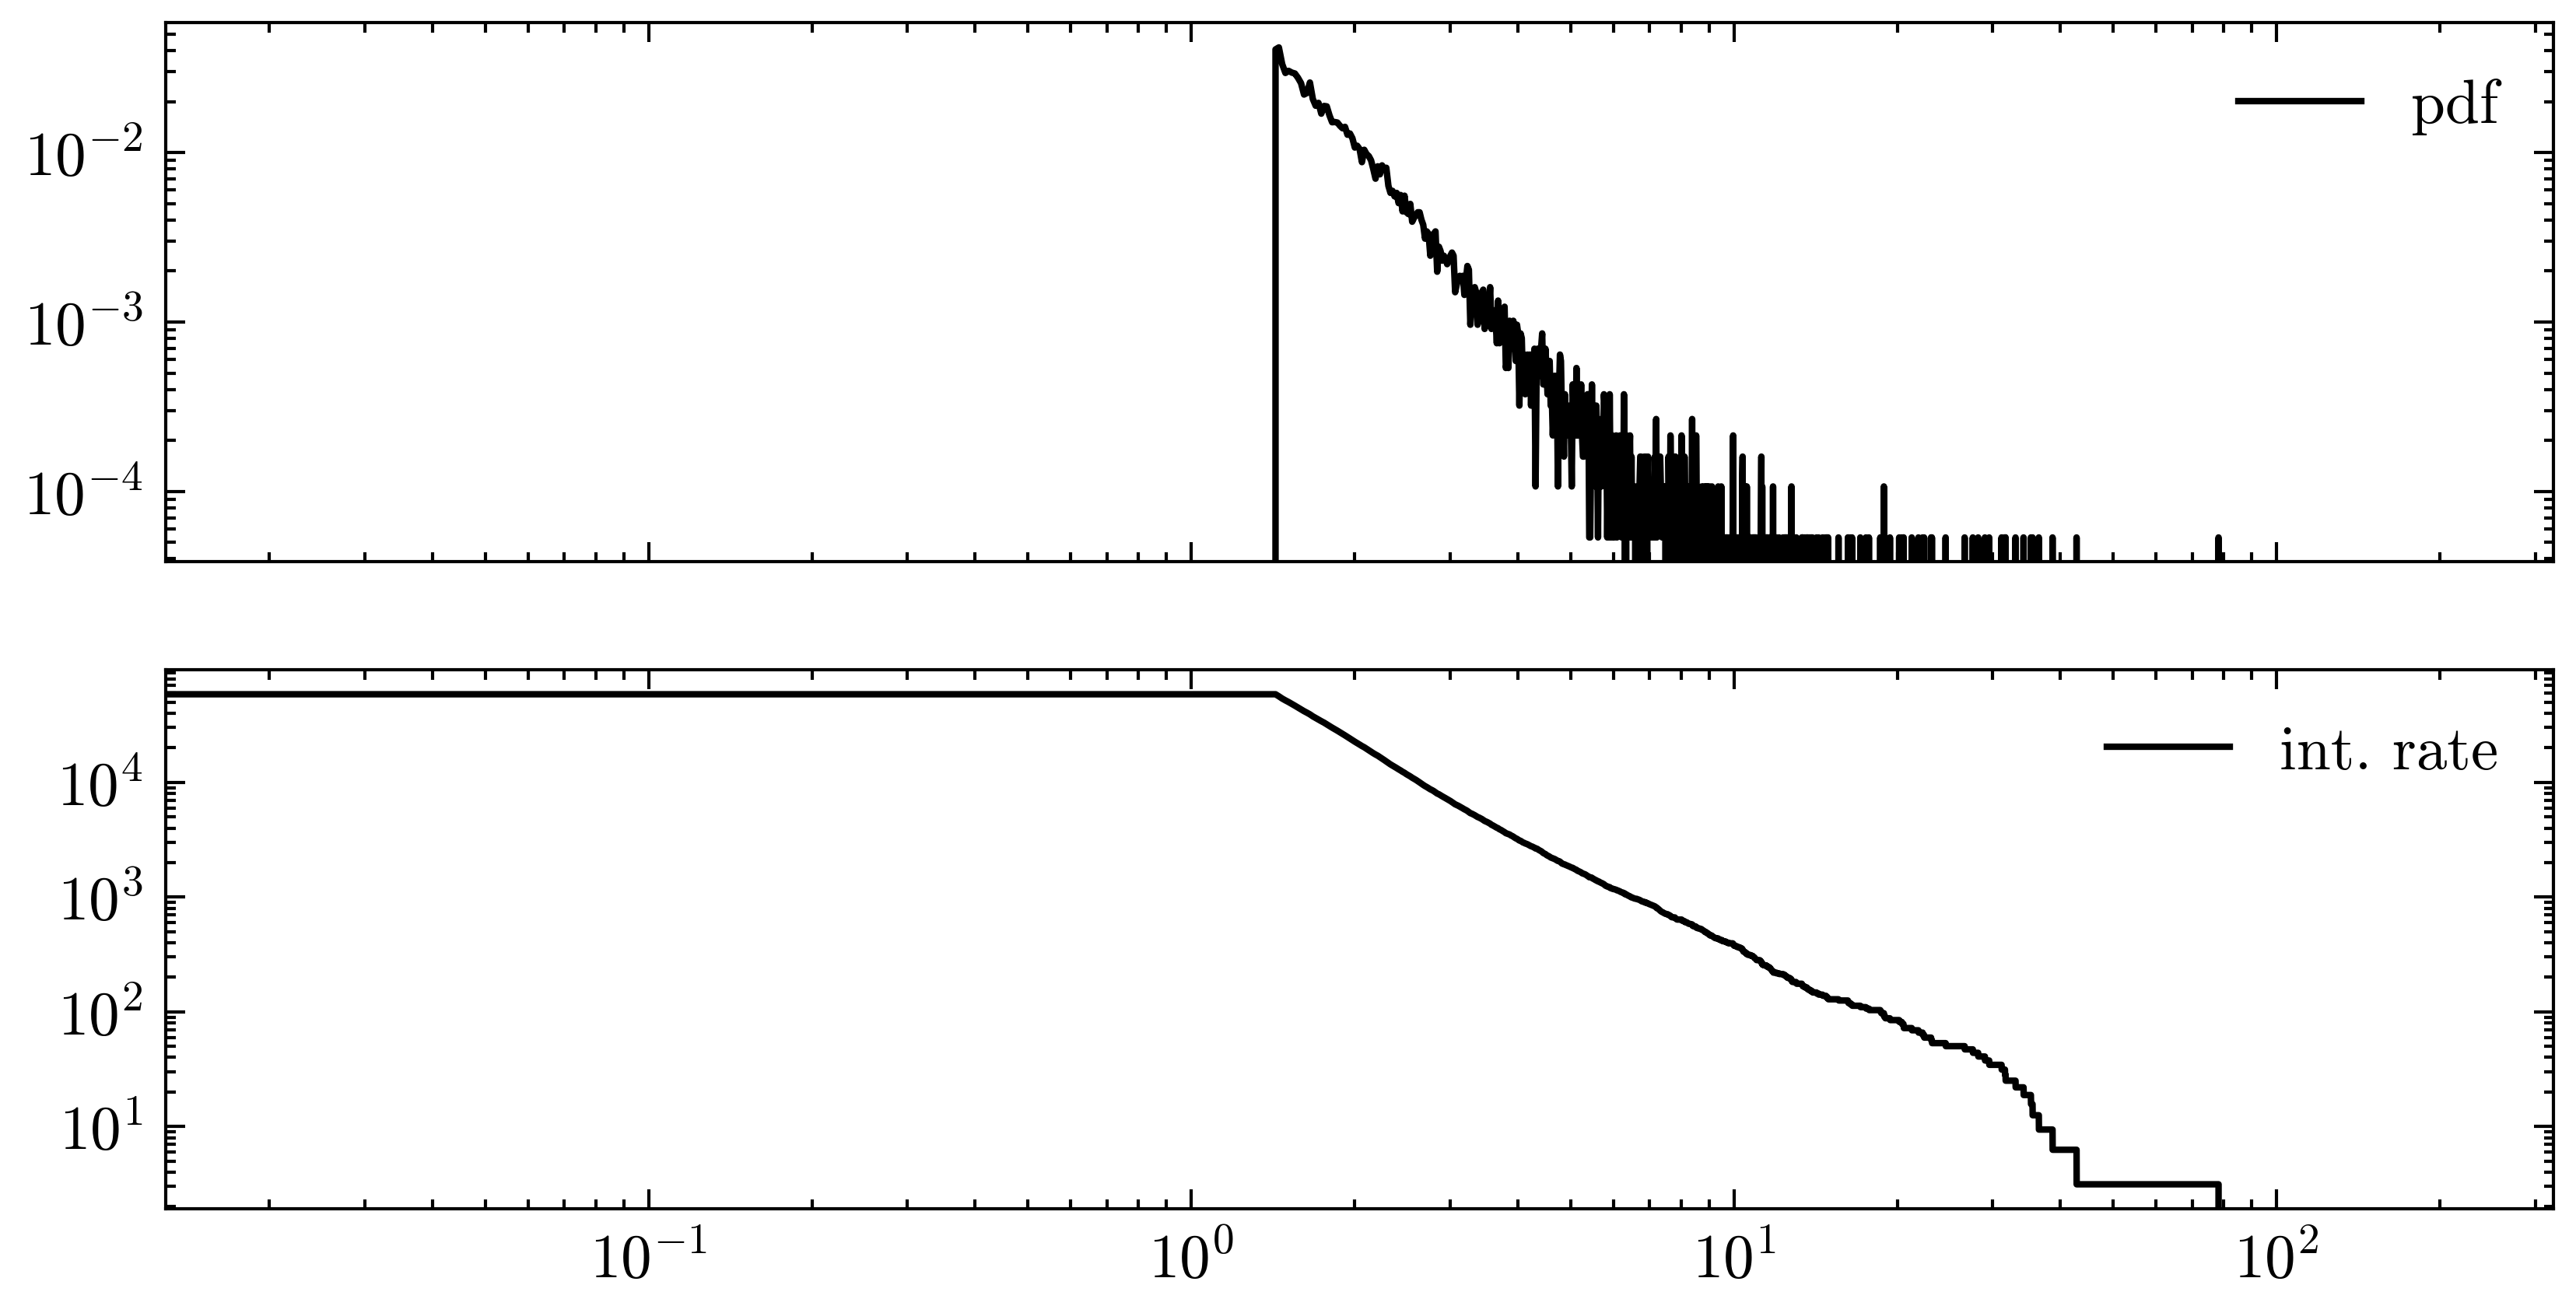

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

px[:70] = 0
cumsum = np.cumsum(px[::-1])[::-1]

ax1.plot(range(10000) / trace['mip_peak'], px/cumsum[0], label='pdf')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()

ax2.plot(range(10000) / trace['mip_peak'], cumsum / (cumsum[0] * 2048 * 8.33e-9), label='int. rate')
ax2.set_yscale('log')
ax2.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


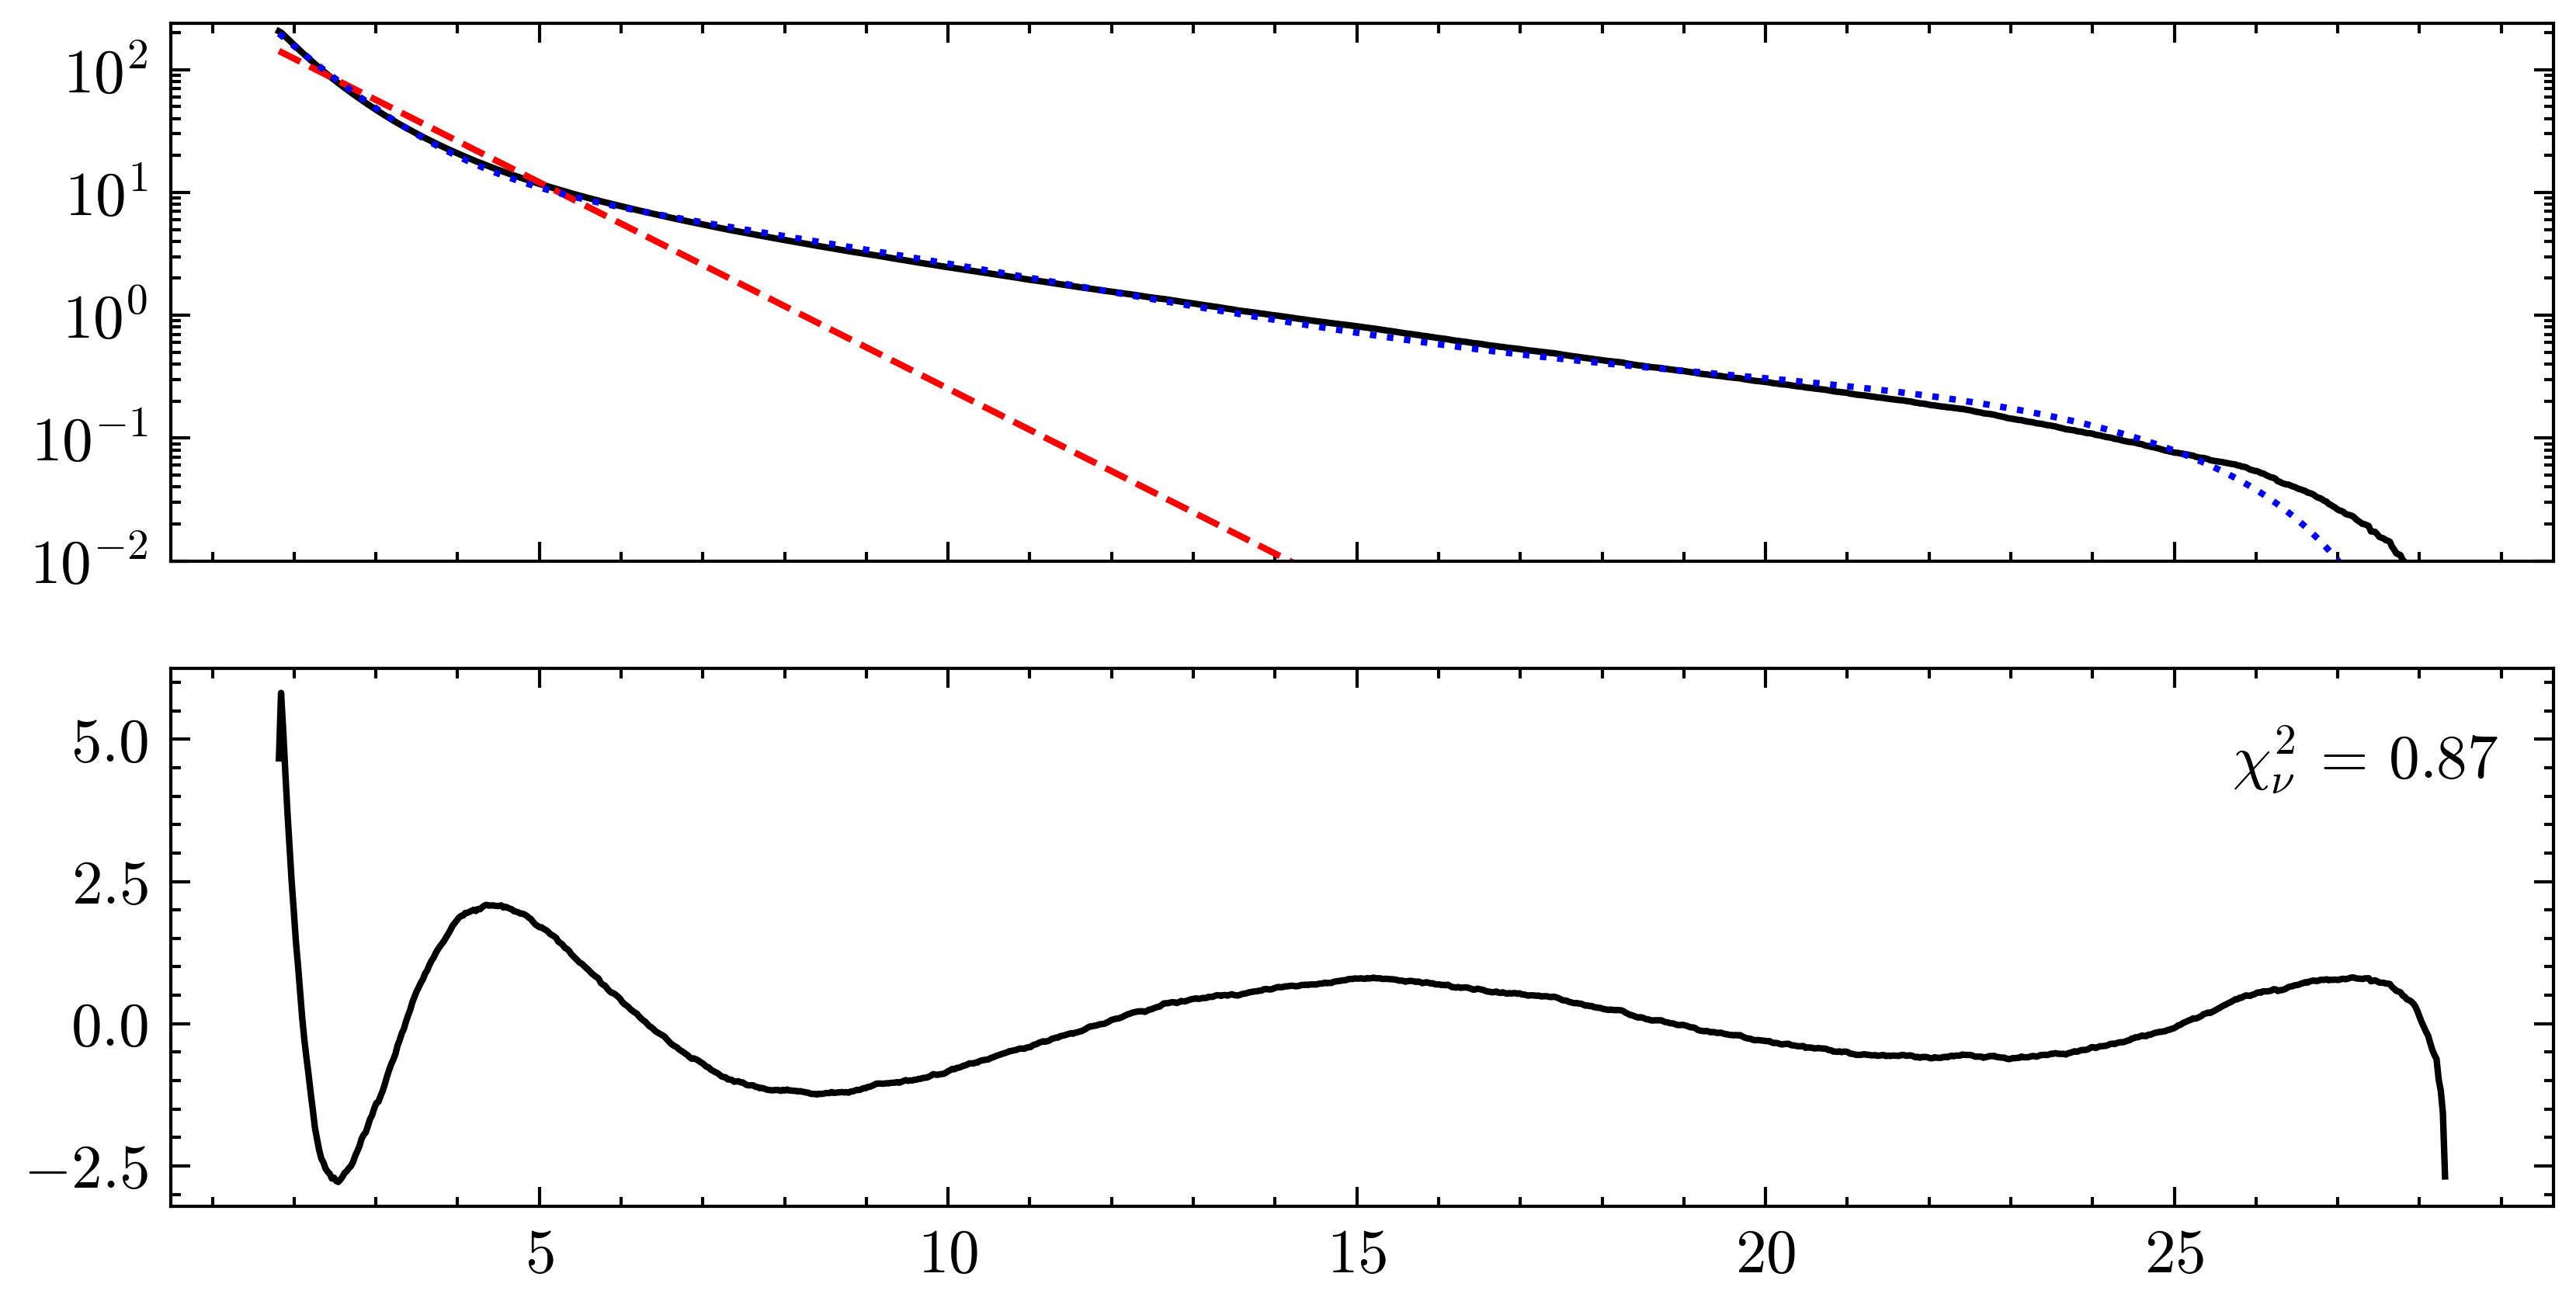

In [5]:
# fitting rate-threshold relationship

from scipy.optimize import curve_fit

def exponential(x, A, mu):
    return A * np.exp(x * mu)

def exponential_corrected(x, A, mu, c, d, e, f, g):
    return A * np.exp(x * mu) + np.poly1d([c, d, e, f, g])(x)

x, y = np.loadtxt('/cr/data01/filip/Data/muonAcquisition/mean_rates_t3_mip.txt', unpack=True)
ERROR = np.sqrt(y / 60)
NDOF = len(x) - 7
bounds_low = [0, -np.inf] + [-np.inf] * 5
bounds_high = [np.inf, 0] + [np.inf] * 5

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(x, y, marker='none')
popt, pcov = curve_fit(exponential, x, y,
                       sigma=ERROR,
                       bounds=(bounds_low[:2], bounds_high[:2]))
ax1.plot(x, exponential(x, *popt), marker='none')

popt, pcov = curve_fit(exponential_corrected, x, y,
                       sigma=ERROR,
                       bounds=(bounds_low, bounds_high))


ax1.plot(x, exponential_corrected(x, *popt), marker='none')
ax1.set_ylim(0.01, 240)
ax1.set_yscale('log')

ax2.plot(x, (y - exponential_corrected(x, *popt)) / ERROR)
ax2.legend(title=fr"$\chi_\nu^2$ = {np.sum((y - exponential_corrected(x, *popt))**2 / ERROR**2 / NDOF):.2f}")
# ax2.set_yscale('log')

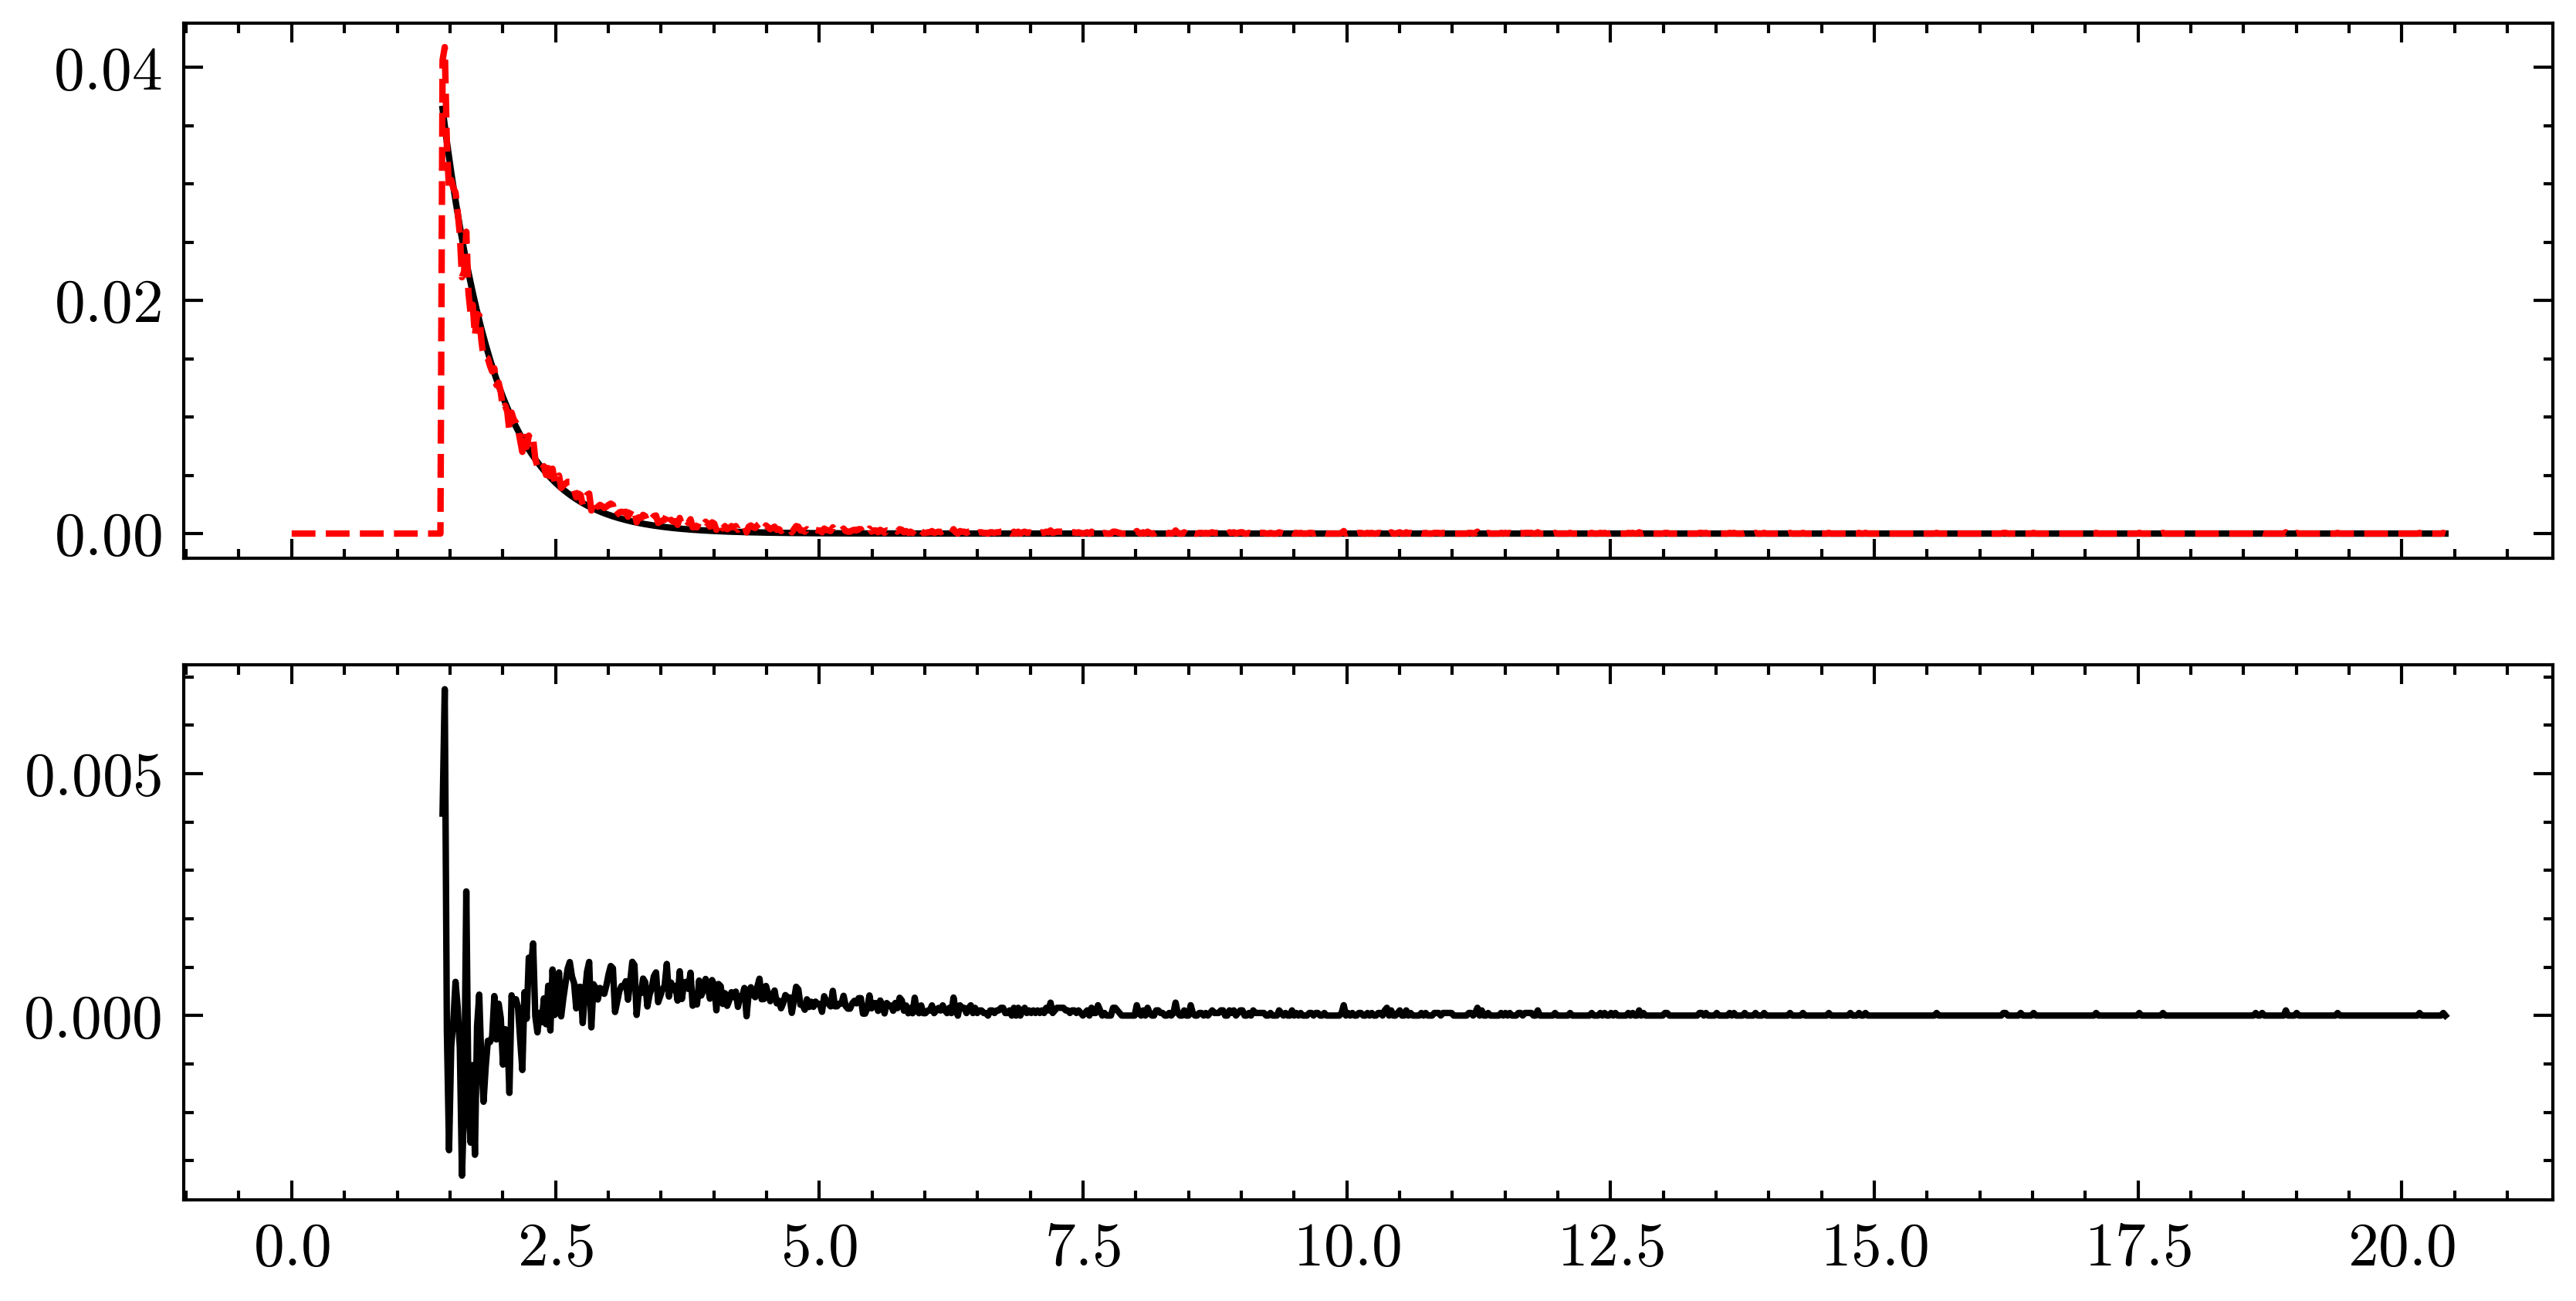

In [6]:
def pdf(x, a, mu):
    return a * np.exp(x*mu)

popt_pdf, pcov = curve_fit(pdf, np.arange(70,1000)/48.94, px[70:1000]/cumsum[0],
                       bounds=([0, -np.inf],[np.inf, 0]))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

X = np.arange(70, 1000) / trace['mip_peak']
ax1.plot(X, pdf(X, *popt_pdf))
ax1.plot(range(1000) / trace['mip_peak'], px[:1000]/cumsum[0], marker='none')

ax2.plot(range(70,1000) / trace['mip_peak'], px[70:1000]/cumsum[0] - pdf(X, *popt_pdf), marker='none')

In [7]:
x  = range(10000) / trace['mip_peak']
px = popt_pdf #px/cumsum[0]
fx = popt #lambda x: exponential_corrected(x, *popt)

tools.pickle_save('x_px_fx.pkl', [x, px, fx])

In [ ]:
trace['mip_peak']